In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather/cleaned_weather.csv


In [2]:
# Importing Cleaned Dataset
df= pd.read_csv("/kaggle/input/weather/cleaned_weather.csv",sep=",")
df.head()

,datetime_utc,conds,dewptm,fog,hum,pressurem,rain,tempm,vism,wspdm
0,19961101-11:00,31,9.0,0,27.0,1010.0,0,30.0,5.0,7.4
1,19961101-12:00,31,10.0,0,32.0,-9999.0,0,28.0,2.0,0.0
2,19961101-13:00,31,11.0,0,44.0,-9999.0,0,24.0,2.0,0.0
3,19961101-14:00,31,10.0,0,41.0,1010.0,0,24.0,2.0,0.0
4,19961101-16:00,31,11.0,0,47.0,1011.0,0,23.0,1.2,0.0


In [3]:
df.shape # After Dropping, we have 10 colums

(98913, 10)

In [4]:
data = df.copy()

In [5]:
data.head()

,datetime_utc,conds,dewptm,fog,hum,pressurem,rain,tempm,vism,wspdm
0,19961101-11:00,31,9.0,0,27.0,1010.0,0,30.0,5.0,7.4
1,19961101-12:00,31,10.0,0,32.0,-9999.0,0,28.0,2.0,0.0
2,19961101-13:00,31,11.0,0,44.0,-9999.0,0,24.0,2.0,0.0
3,19961101-14:00,31,10.0,0,41.0,1010.0,0,24.0,2.0,0.0
4,19961101-16:00,31,11.0,0,47.0,1011.0,0,23.0,1.2,0.0


In [6]:
### Filtering only datetime and tempm
data = data[['datetime_utc','tempm']]
data.head()

,datetime_utc,tempm
0,19961101-11:00,30.0
1,19961101-12:00,28.0
2,19961101-13:00,24.0
3,19961101-14:00,24.0
4,19961101-16:00,23.0


In [7]:
data["date"] = pd.to_datetime(data['datetime_utc'], infer_datetime_format=True)
data = data.set_index(["date"])

In [8]:
data["date"]=pd.to_datetime(data["datetime_utc"],format="%Y%m%d-%H:%M")
data.dtypes

datetime_utc            object
tempm                  float64
date            datetime64[ns]
dtype: object

In [9]:
data=data.set_index("date")
data.head() #Making Date has Index

,datetime_utc,tempm
date,,
1996-11-01 11:00:00,19961101-11:00,30.0
1996-11-01 12:00:00,19961101-12:00,28.0
1996-11-01 13:00:00,19961101-13:00,24.0
1996-11-01 14:00:00,19961101-14:00,24.0
1996-11-01 16:00:00,19961101-16:00,23.0


In [10]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 924 kB/s            


In [11]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

In [12]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

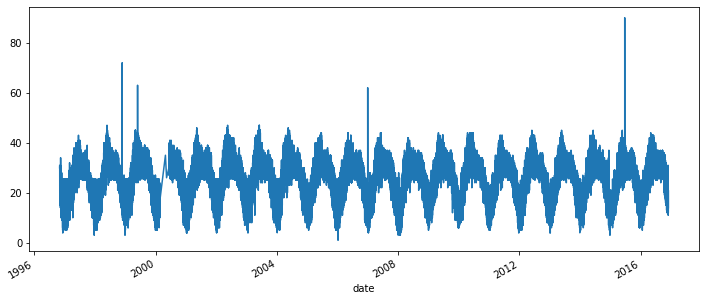

In [13]:
data['tempm'].plot(figsize=(12,5));

In [14]:
data['mavg_12'] = data['tempm'].rolling(window=12).mean().shift(1)

In [15]:
pd.set_option('display.float_format',lambda x:'%.2f' %x)
data[['tempm','mavg_12']][12:]

,tempm,mavg_12
date,,
1996-11-02 00:00:00,19.00,22.33
1996-11-02 01:00:00,19.00,21.42
1996-11-02 02:00:00,20.00,20.67
1996-11-02 03:00:00,22.00,20.33
1996-11-02 04:00:00,23.00,20.17
...,...,...
2016-11-30 12:30:00,21.00,23.33
2016-11-30 13:00:00,19.00,23.67
2016-11-30 15:00:00,17.00,23.67


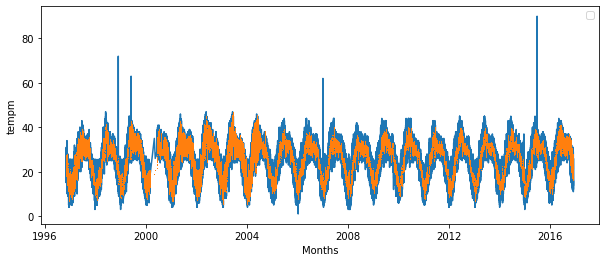

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.xlabel("Months")
plt.ylabel('tempm')
plt.plot(data['tempm'][12:])
plt.plot(data['mavg_12'][12:],',')
plt.legend()

In [17]:
def get_mape(actual,predicted):
  y_true,y_pred = np.array(actual),np.array(predicted)
  return np.round(np.mean(np.abs((actual-predicted)/actual))*100,2)

In [18]:
get_mape(data['tempm'][12:].values,data['mavg_12'][12:].values)

17.58

In [19]:
#MAPE of Moving Average is 17.58%

In [20]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(data['tempm'][12:].values,data['mavg_12'][12:].values))

4.540206621461131

In [21]:
#### RMSE Value of moving average has 4.54 SD

In [22]:
# Exponential Smooting
data['ewm']=data['tempm'].ewm(alpha=0.2).mean()

In [23]:
pd.options.display.float_format='{:.2f}'.format

In [24]:
data[12:]

,datetime_utc,tempm,mavg_12,ewm
date,,,,
1996-11-02 00:00:00,19961102-00:00,19.00,22.33,20.06
1996-11-02 01:00:00,19961102-01:00,19.00,21.42,19.84
1996-11-02 02:00:00,19961102-02:00,20.00,20.67,19.87
1996-11-02 03:00:00,19961102-03:00,22.00,20.33,20.31
1996-11-02 04:00:00,19961102-04:00,23.00,20.17,20.86
...,...,...,...,...
2016-11-30 12:30:00,20161130-12:30,21.00,23.33,23.07
2016-11-30 13:00:00,20161130-13:00,19.00,23.67,22.25
2016-11-30 15:00:00,20161130-15:00,17.00,23.67,21.20


In [25]:
get_mape(data[['tempm']][12:].values,data[['ewm']][12:].values)

11.57

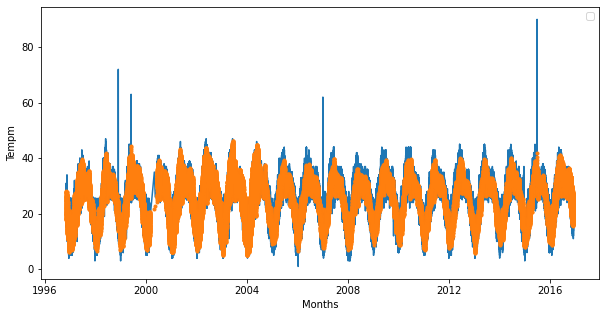

In [26]:
plt.figure(figsize=(10,5))
plt.xlabel("Months")
plt.ylabel("Tempm")
plt.plot(data['tempm'][12:])
plt.plot(data['ewm'][12:],'.')
plt.legend()

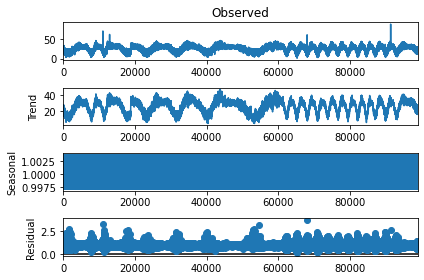

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_decompose = seasonal_decompose(np.array(data['tempm']),model = "multiplicative",period=12)
ts_plot = ts_decompose.plot()

In [28]:
data.tail()

,datetime_utc,tempm,mavg_12,ewm
date,,,,
2016-11-30 12:30:00,20161130-12:30,21.00,23.33,23.07
2016-11-30 13:00:00,20161130-13:00,19.00,23.67,22.25
2016-11-30 15:00:00,20161130-15:00,17.00,23.67,21.20
2016-11-30 18:00:00,20161130-18:00,15.00,23.33,19.96
2016-11-30 21:00:00,20161130-21:00,14.00,22.67,18.77


In [29]:
#### Tempm in data has a trend which is decreasing over a period. 

In [30]:
adf_test(data['tempm'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -7.60
p-value                    0.00
# lags used               68.00
# observations         98844.00
critical value (1%)       -3.43
critical value (5%)       -2.86
critical value (10%)      -2.57
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [31]:
#### As P-Value is less than 0.05, we can reject the Null Hypothesis. Hence, the data is stationary.

<AxesSubplot:xlabel='date'>

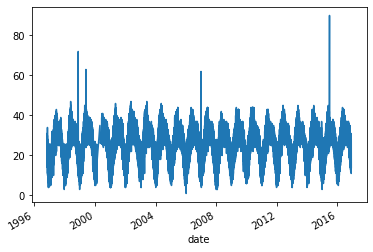

In [32]:
data['tempm'].plot()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


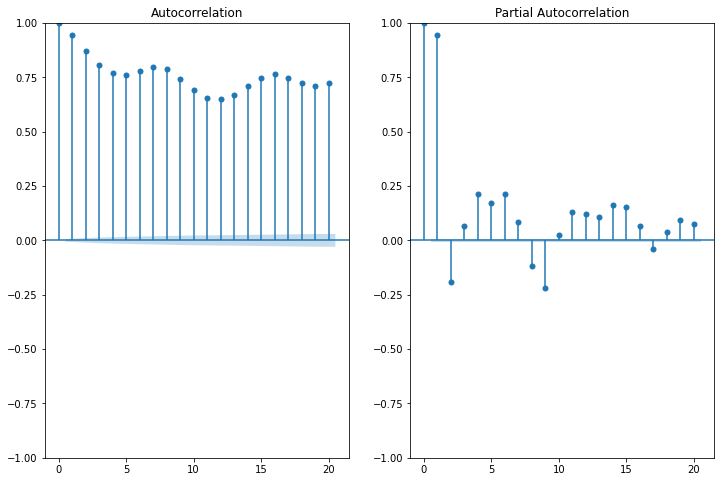

In [33]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(data['tempm'],lags=20,ax=ax1)
ax1 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(data['tempm'],lags=20,ax=ax1)

In [34]:
import statsmodels.api as sm

In [35]:
data.shape

(98913, 4)

In [36]:
data_train=data[0:80000]
data_test=data[80000:]

In [37]:
data_train

,datetime_utc,tempm,mavg_12,ewm
date,,,,
1996-11-01 11:00:00,19961101-11:00,30.00,NaN,30.00
1996-11-01 12:00:00,19961101-12:00,28.00,NaN,28.89
1996-11-01 13:00:00,19961101-13:00,24.00,NaN,26.89
1996-11-01 14:00:00,19961101-14:00,24.00,NaN,25.91
1996-11-01 16:00:00,19961101-16:00,23.00,NaN,25.04
...,...,...,...,...
2011-03-21 18:00:00,20110321-18:00,20.00,25.92,24.67
2011-03-21 21:00:00,20110321-21:00,19.00,25.75,23.54
2011-03-22 00:00:00,20110322-00:00,16.00,24.83,22.03


In [38]:
from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(data_train['tempm'])
model_fit=model.fit()
model_fit.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  tempm   No. Observations:                80000
Model:                          ARIMA   Log Likelihood             -284760.542
Date:                Wed, 02 Mar 2022   AIC                         569525.084
Time:                        15:48:23   BIC                         569543.663
Sample:                             0   HQIC                        569530.779
                              - 80000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.3990      0.031    812.923      0.000      25.338      25.460
sigma2        72.3242      0.454    159.232      0.000      71.434      73.214
===================================================================================
Ljung-Box (L1) (Q):               72616.84   Jarque-Bera (JB):              2675.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.32
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

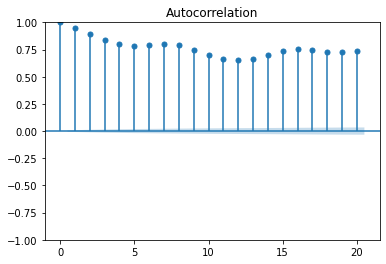

In [39]:
acf_plot = plot_acf(model_fit.resid,lags = 20)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


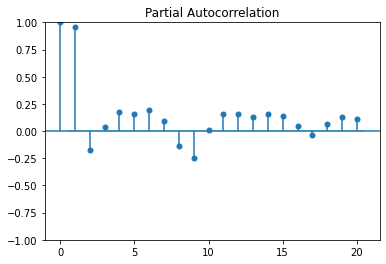

In [40]:
pacf_plot = plot_pacf(model_fit.resid,lags = 20)

In [41]:
temp_predict,stderr,ci=model_fit.forecast(steps=3)
temp_predict

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


25.398980324040643

In [42]:
get_mape(data['tempm'][100:],temp_predict)

38.46

In [43]:
#### The ARIMA Model gives forecast accuracy of 38.46%

In [44]:
#### DEEP LEARNING

In [45]:
data.head()

,datetime_utc,tempm,mavg_12,ewm
date,,,,
1996-11-01 11:00:00,19961101-11:00,30.00,NaN,30.00
1996-11-01 12:00:00,19961101-12:00,28.00,NaN,28.89
1996-11-01 13:00:00,19961101-13:00,24.00,NaN,26.89
1996-11-01 14:00:00,19961101-14:00,24.00,NaN,25.91
1996-11-01 16:00:00,19961101-16:00,23.00,NaN,25.04


In [46]:
df.head()

,datetime_utc,conds,dewptm,fog,hum,pressurem,rain,tempm,vism,wspdm
0,19961101-11:00,31,9.00,0,27.00,1010.00,0,30.00,5.00,7.40
1,19961101-12:00,31,10.00,0,32.00,-9999.00,0,28.00,2.00,0.00
2,19961101-13:00,31,11.00,0,44.00,-9999.00,0,24.00,2.00,0.00
3,19961101-14:00,31,10.00,0,41.00,1010.00,0,24.00,2.00,0.00
4,19961101-16:00,31,11.00,0,47.00,1011.00,0,23.00,1.20,0.00


#### Performing Deep Learning Model

In [47]:
# NN
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

In [48]:
df1=df.copy()

In [49]:
df1["date"]=pd.to_datetime(df1["datetime_utc"],format="%Y%m%d-%H:%M")
df1.dtypes

datetime_utc            object
conds                    int64
dewptm                 float64
fog                      int64
hum                    float64
pressurem              float64
rain                     int64
tempm                  float64
vism                   float64
wspdm                  float64
date            datetime64[ns]
dtype: object

In [50]:
df1=df1.set_index("date")
df1.head()

,datetime_utc,conds,dewptm,fog,hum,pressurem,rain,tempm,vism,wspdm
date,,,,,,,,,,
1996-11-01 11:00:00,19961101-11:00,31,9.00,0,27.00,1010.00,0,30.00,5.00,7.40
1996-11-01 12:00:00,19961101-12:00,31,10.00,0,32.00,-9999.00,0,28.00,2.00,0.00
1996-11-01 13:00:00,19961101-13:00,31,11.00,0,44.00,-9999.00,0,24.00,2.00,0.00
1996-11-01 14:00:00,19961101-14:00,31,10.00,0,41.00,1010.00,0,24.00,2.00,0.00
1996-11-01 16:00:00,19961101-16:00,31,11.00,0,47.00,1011.00,0,23.00,1.20,0.00


In [51]:
df1 = df1.drop(['datetime_utc'],axis=1)

In [52]:
X = df1.drop(['tempm'],axis=1)
Y=df1['tempm']

In [53]:
X_train, X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.2, random_state= 2)
print(X_train.shape, Y_train.shape, X_test.shape,Y_test.shape)

(79130, 8) (79130,) (19783, 8) (19783,)


In [54]:
Y_train.shape

(79130,)

#### Data Pre-Processing

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =  scaler.fit_transform(X_test)

In [56]:
X_train_scaled.shape

(79130, 8)

In [57]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor = "loss",patience = 5)

In [58]:
model = Sequential()
model.add(Dense(units = 32, input_dim = 8, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 32, activation="relu"))
model.add(Dense(1))
model.compile(loss = "mse", optimizer = "adam")
history = model.fit(X_train_scaled, Y_train,batch_size = 25, epochs = 50, callbacks = [callbacks])

2022-03-02 15:48:36.375634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 15:48:36.477621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 15:48:36.478500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 15:48:36.479956: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/50
3166/3166 [==============================] - 8s 2ms/step - loss: 144.5686
Epoch 2/50
3166/3166 [==============================] - 7s 2ms/step - loss: 110.6671
Epoch 3/50
3166/3166 [==============================] - 7s 2ms/step - loss: 128.1106
Epoch 4/50
3166/3166 [==============================] - 7s 2ms/step - loss: 60.2536
Epoch 5/50
3166/3166 [==============================] - 7s 2ms/step - loss: 44.3134
Epoch 6/50
3166/3166 [==============================] - 7s 2ms/step - loss: 21.7448
Epoch 7/50
3166/3166 [==============================] - 7s 2ms/step - loss: 12.8126
Epoch 8/50
3166/3166 [==============================] - 7s 2ms/step - loss: 7.7267
Epoch 9/50
3166/3166 [==============================] - 7s 2ms/step - loss: 5.2740
Epoch 10/50
3166/3166 [==============================] - 7s 2ms/step - loss: 4.4638
Epoch 11/50
3166/3166 [==============================] - 7s 2ms/step - loss: 3.9967
Epoch 12/50
3166/3166 [==============================] - 8s 2ms/step - loss

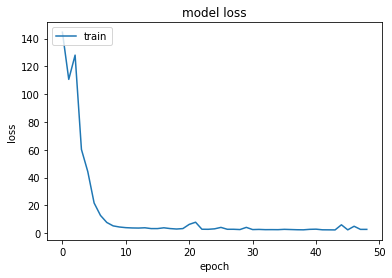

In [59]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [60]:
preds = model.predict(X_test_scaled)

In [61]:
preds

array([[28.14903 ],
       [28.139011],
       [23.844564],
       ...,
       [13.168217],
       [32.967735],
       [29.38517 ]], dtype=float32)

In [62]:
preds=pd.DataFrame(preds)

In [63]:
#### These are the Prediction Values for Deep Learning Model
preds

,0
0,28.15
1,28.14
2,23.84
3,12.27
4,34.84
...,...
19778,29.31
19779,31.59
19780,13.17
19781,32.97
